# Gradient Boosting Trees : Learning Regression

## Objectives

Pada proyek ini, kita akan melakukan modeling pada data penjualan rumah untuk memprediksi harga rumah. Prediksi akan dilakukan dengan melakukan percobaan pada tiga model dimana model yang akan digunakan terbatas pada gradient boosting trees. Adapun model yang terpilih adalah: Gradient Boosting Regressor, XGBoost Regressor, dan LightGBM Regressor. Kemudian, dari ketiga model tersebut akan dianalisa hasil prediksi masing - masing dan disimpulkan mana diantara ketiga tersebut yang terbaik untuk kasus ini.

## Import Library dan Data

In [ ]:
# Perlu diinstall untuk keperluan beberapa regressor yang diimport (atas rekomendasi dari python).
!pip install "dask[dataframe]"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/aufabi/belajar-git/refs/heads/main/Dataset%20-%20House%20Prices%20-%20Advanced%20Regression%20Techniques/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/aufabi/belajar-git/refs/heads/main/Dataset%20-%20House%20Prices%20-%20Advanced%20Regression%20Techniques/test.csv')
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

## Data Preprocessing

### Missing Values

Pertama, kita akan cek apakah ada missing values pada data ini.

In [ ]:
pro = df_train.isnull().sum()/len(df_train)
data_pro = {'Missing Values Total':[x for x in df_train.isnull().sum()], 'Percentage': [str(round(x*100,2))+'%' for x in pro]}
percentage = pd.DataFrame(data_pro, index=list(df_train.columns))
percentage

Missing Values Total Percentage
Id                                0       0.0%
MSSubClass                        0       0.0%
MSZoning                          0       0.0%
LotFrontage                     259     17.74%
LotArea                           0       0.0%
...                             ...        ...
MoSold                            0       0.0%
YrSold                            0       0.0%
SaleType                          0       0.0%
SaleCondition                     0       0.0%
SalePrice                         0       0.0%

[81 rows x 2 columns]

Terdapat banyak missing values pada data ini, namun sebelum kita handle, kita perlu analisa terlebih dahulu dan mencocokkannya dengan data_description.txt sebelum menentukan apa yang akan kita lakukan pada missing values tersebut. Pada kolom LotFrontage dan , values berupa numerik, sehingga kita bisa isi missing values menggunakan median. Kita juga akan lakukan hal yang sama pada data test dengan menggunakan median dari data train untuk menghindari data leakage.

In [ ]:
# Imputasi pada data train
kondisi = df_train['LotFrontage'].notnull()
med = df_train[kondisi].LotFrontage.median()
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(med)

# Imputasi pada data test
df_test['LotFrontage'] = df_test['LotFrontage'].fillna(med)

# Cek missing values pada train
df_train['LotFrontage'].isnull().sum()

0

Pada kolom MasVnrType dijelaskan bahwa memang ada value None untuk menunjukkan bahwa tidak ada masonry veneer. Kolom MasVnrType dan MasVnrArea berkaitan karena apabila benar MasVnrType nya None maka harusnya MasVnrArea nya juga 0. Jadi, akan kita cek kondisi kedua kolom ini saat MasVnrType nya none.

In [ ]:
cek = df_train[df_train['MasVnrType'].isnull()]
cek[['MasVnrType','MasVnrArea']]

MasVnrType  MasVnrArea
1           NaN         0.0
3           NaN         0.0
5           NaN         0.0
8           NaN         0.0
9           NaN         0.0
...         ...         ...
1454        NaN         0.0
1455        NaN         0.0
1457        NaN         0.0
1458        NaN         0.0
1459        NaN         0.0

[872 rows x 2 columns]

Terlihat bahwa terdapat MasVnrArea yang tidak 0, sehingga akan kita isi MasVnrType menjadi None untuk MasVnrArea = 0 dan akan kita isi MasVnrType dengan modus ketika MasVnrArea tidak 0 dan tidak missing.

In [ ]:
# Data train
kondisi = df_train['MasVnrType'].isnull() & df_train['MasVnrArea'].notnull() & df_train['MasVnrArea'] == 0
df_train.loc[kondisi, 'MasVnrType'] = 'None'

kondisi = df_train['MasVnrType'].isnull() & df_train['MasVnrArea'].notnull() & df_train['MasVnrArea'] != 0
kondisi_modus = df_train['MasVnrType'].notnull() & df_train['MasVnrArea'].notnull() & df_train['MasVnrArea'] != 0
modus = df_train[kondisi_modus].MasVnrType.mode()[0]
df_train.loc[kondisi, 'MasVnrType'] = modus

# Data test
kondisi = df_test['MasVnrType'].isnull() & df_test['MasVnrArea'].notnull() & df_test['MasVnrArea'] == 0
df_test.loc[kondisi, 'MasVnrType'] = 'None'

kondisi = df_test['MasVnrType'].isnull() & df_test['MasVnrArea'].notnull() & df_test['MasVnrArea'] != 0
df_test.loc[kondisi, 'MasVnrType'] = modus

# Cek sisa missing
df_train['MasVnrType'].isnull().sum()

0

Berikutnya, mari kita cek kondisi missing values pada MasVnrArea. Apakah nilai missing pada MasVnrArea ini berkaitan dengan tidak adanya MasVnrType.

In [ ]:
cek = df_train[df_train['MasVnrArea'].isnull()]
cek[['MasVnrType','MasVnrArea']]

MasVnrType  MasVnrArea
234        None         NaN
529        None         NaN
650        None         NaN
936        None         NaN
973        None         NaN
977        None         NaN
1243       None         NaN
1278       None         NaN

Terlihat bahwa pada missing values tersebut, MasVnrType juga None, sehingga akan kit isi dengan 0.

In [ ]:
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)

df_train['MasVnrArea'].isnull().sum()

0

Selanjutnya, kita akan isi missing values pada beberapa kolom berikut dengan NA sesuai dengan deskripsi pada data_description.txt.

In [ ]:
isina = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
         'Fence', 'MiscFeature']
for col in isina:
  df_train[col] = df_train[col].fillna('NA')
  df_test[col] = df_test[col].fillna('NA')

In [ ]:
pro = df_train.isnull().sum()/len(df_train)
data_pro = {'Missing Values Total':[x for x in df_train.isnull().sum()], 'Percentage': [str(round(x*100,2))+'%' for x in pro]}
percentage = pd.DataFrame(data_pro, index=list(df_train.columns))
percentage

Missing Values Total Percentage
Id                                0       0.0%
MSSubClass                        0       0.0%
MSZoning                          0       0.0%
LotFrontage                       0       0.0%
LotArea                           0       0.0%
...                             ...        ...
MoSold                            0       0.0%
YrSold                            0       0.0%
SaleType                          0       0.0%
SaleCondition                     0       0.0%
SalePrice                         0       0.0%

[81 rows x 2 columns]

Kolom BsmtExposure memiliki missing value lebih dari BsmtQual, oleh karenanya untuk BsmtQual NA kita isi BsmtExposure NA sedangkan untuk BsmtQual nya tidak NA maka kita isi BsmtExposure dengan modus.

In [ ]:
# Data Train
kondisi = df_train.BsmtQual == 'NA'
df_train.loc[kondisi, 'BsmtExposure'] = 'NA'

kondisi = df_train.BsmtExposure.isnull() & df_train.BsmtQual != 'NA'
kondisi_modus = df_train.BsmtExposure.notnull() & df_train.BsmtQual != 'NA'
modus = df_train[kondisi_modus].BsmtExposure.mode()[0]
df_train.loc[kondisi, 'BsmtExposure'] = modus

# Data Test
kondisi = df_test.BsmtQual == 'NA'
df_test.loc[kondisi, 'BsmtExposure'] = 'NA'

kondisi = df_test.BsmtExposure.isnull() & df_test.BsmtQual != 'NA'
df_test.loc[kondisi, 'BsmtExposure'] = modus

# Cek
df_train['BsmtExposure'].isnull().sum()

0

Dengan cara yang sama, kita handle missing value pada BsmtFinType2.

In [ ]:
# Data train
kondisi = df_train.BsmtQual == 'NA'
df_train.loc[kondisi, 'BsmtFinType2'] = 'NA'

kondisi = df_train.BsmtFinType2.isnull() & df_train.BsmtQual != 'NA'
kondisi_modus = df_train.BsmtFinType2.notnull() & df_train.BsmtQual != 'NA'
modus = df_train[kondisi_modus].BsmtFinType2.mode()[0]
df_train.loc[kondisi, 'BsmtFinType2'] = modus

# Data test
kondisi = df_test.BsmtQual == 'NA'
df_test.loc[kondisi, 'BsmtFinType2'] = 'NA'

kondisi = df_test.BsmtFinType2.isnull() & df_test.BsmtQual != 'NA'
df_test.loc[kondisi, 'BsmtFinType2'] = modus

# Cek
df_train['BsmtFinType2'].isnull().sum()

0

Lalu, kita akan isi missing values pada electrical dengan modus.

In [ ]:
kondisi = df_train['Electrical'].notnull()
modus = df_train[kondisi].Electrical.mode()[0]

df_train.Electrical = df_train.Electrical.fillna(modus)
df_test.Electrical = df_test.Electrical.fillna(modus)

df_train.Electrical.isnull().sum()

0

Sekarang coba kita cek kondisi ketika GarageYrBlt missing.

In [ ]:
df_train[df_train.GarageYrBlt.isnull()][['GarageType', 'GarageYrBlt']]

GarageType  GarageYrBlt
39           NA          NaN
48           NA          NaN
78           NA          NaN
88           NA          NaN
89           NA          NaN
...         ...          ...
1349         NA          NaN
1407         NA          NaN
1449         NA          NaN
1450         NA          NaN
1453         NA          NaN

[81 rows x 2 columns]

Terlihat bahwa semua bertepatan dengan tidak adanya garasi. Oleh karena itu, akan kita isi dengan 0.

In [ ]:
df_train.GarageYrBlt = df_train.GarageYrBlt.fillna(0)
df_test.GarageYrBlt = df_test.GarageYrBlt.fillna(0)

df_train.GarageYrBlt.isnull().sum()

0

In [ ]:
pro = df_train.isnull().sum()/len(df_train)
data_pro = {'Missing Values Total':[x for x in df_train.isnull().sum()], 'Percentage': [str(round(x*100,2))+'%' for x in pro]}
percentage = pd.DataFrame(data_pro, index=list(df_train.columns))
percentage

Missing Values Total Percentage
Id                                0       0.0%
MSSubClass                        0       0.0%
MSZoning                          0       0.0%
LotFrontage                       0       0.0%
LotArea                           0       0.0%
...                             ...        ...
MoSold                            0       0.0%
YrSold                            0       0.0%
SaleType                          0       0.0%
SaleCondition                     0       0.0%
SalePrice                         0       0.0%

[81 rows x 2 columns]

Terlihat data sudah bersih, sehingga kita bisa lanjut ke tahap berikutnya.

### Duplicated Values

Lalu kita cek apakah terdapat data duplikat pada df_train.

In [ ]:
num_dup = df_train.duplicated().sum()
per_dup = str(round(num_dup/len(df_train)*100,2)) + '%'

print(f'Jumlah nilai duplikat adalah {num_dup} yaitu {per_dup} dari keseluruhan data.')

Jumlah nilai duplikat adalah 0 yaitu 0.0% dari keseluruhan data.


### Encoding

Akan kita cek dahulu seperti apa unique values dari setiap kolom sebelum menentukan encoding yang akan dilakukan.

In [ ]:
categorical = df_train.select_dtypes(include=['object', 'category']).columns

for x in categorical:
  print(f'{x}:')
  print(f'{df_train[x].unique()}\n')

MSZoning:
['RL' 'RM' 'C (all)' 'FV' 'RH']

Street:
['Pave' 'Grvl']

Alley:
['NA' 'Grvl' 'Pave']

LotShape:
['Reg' 'IR1' 'IR2' 'IR3']

LandContour:
['Lvl' 'Bnk' 'Low' 'HLS']

Utilities:
['AllPub' 'NoSeWa']

LotConfig:
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']

LandSlope:
['Gtl' 'Mod' 'Sev']

Neighborhood:
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']

Condition1:
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']

Condition2:
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']

BldgType:
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']

HouseStyle:
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']

RoofStyle:
['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']

RoofMatl:
['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']

E

Akan kita aplikasikan one hot encoding pada kolom kategorikal.

In [ ]:
df_encoded = pd.get_dummies(df_train, columns=categorical, dtype=int, drop_first=True)
df_test = pd.get_dummies(df_test, columns=categorical, dtype=int, drop_first=True)

# Menyamakan index pada test
cols = df_encoded.columns
cols = cols.drop('SalePrice')
df_test = df_test.reindex(columns=cols, fill_value=0)

df_encoded.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  SaleType_ConLw  \
0          2003       196.0         706  ...               0               0   
1          1976         0.0         978  ...               0               0   
2          2002       162.0         486  ...               0               0   
3          1970         0.0         216  ...               0               0   
4          2000       350.0         655  ...               0               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      0   
4             0             0            1                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 248 columns]

### Train Test Split

Karena data sudah terbagi menjadi train dan test, maka pada tahap ini, kita hanya perlu membagi antara features dan target.

In [ ]:
X_train = df_encoded.drop('SalePrice', axis=1)
y_train = df_encoded['SalePrice']

X_train.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  SaleType_ConLw  \
0          2003       196.0         706  ...               0               0   
1          1976         0.0         978  ...               0               0   
2          2002       162.0         486  ...               0               0   
3          1970         0.0         216  ...               0               0   
4          2000       350.0         655  ...               0               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      0   
4             0             0            1                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 247 columns]

## Exploratory Data Analysis

Agar mudah diinterpretasi, untuk keperluan analisis, kita akan menggunakan df sebelum di encode.

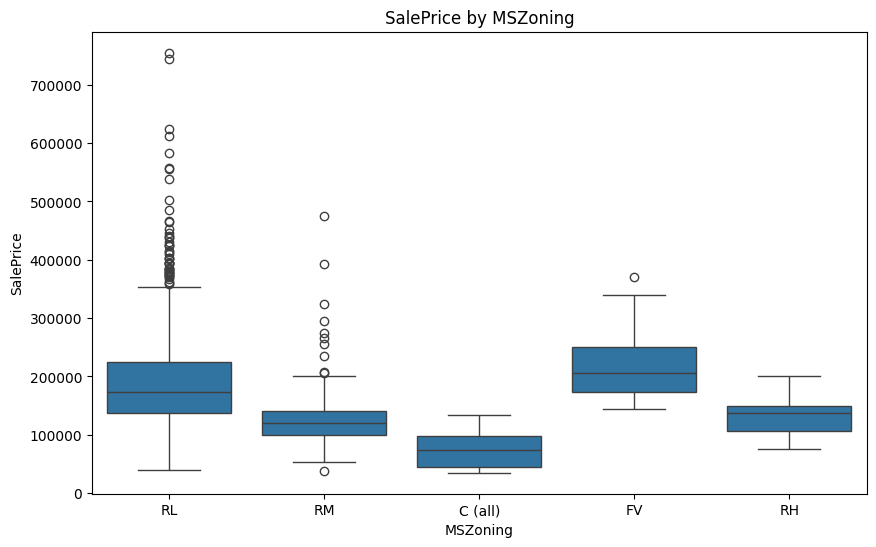

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='MSZoning', y='SalePrice', data=df_train)
plt.title("SalePrice by MSZoning")
plt.show()

Dari visualisasi di atas diperoleh bahwa rumah dengan RL (Residential low density) atau dengan kepadatan rendah memiliki rentang harga yang paling luas diantara zona lainnya. Artinya, rumah RL ini memiliki banyak peminat dari berbagai macam level kekayaan. Rumah pada zona C (commercial) memiliki rentang harga paling rendah di antara yang lain. Bersama dengan zona RH (residential high density), keduanya tidak memiliki outliers yang berarti kedua zona tersebut tidak memiliki harga rumah yang diluar harga pada umumnya.

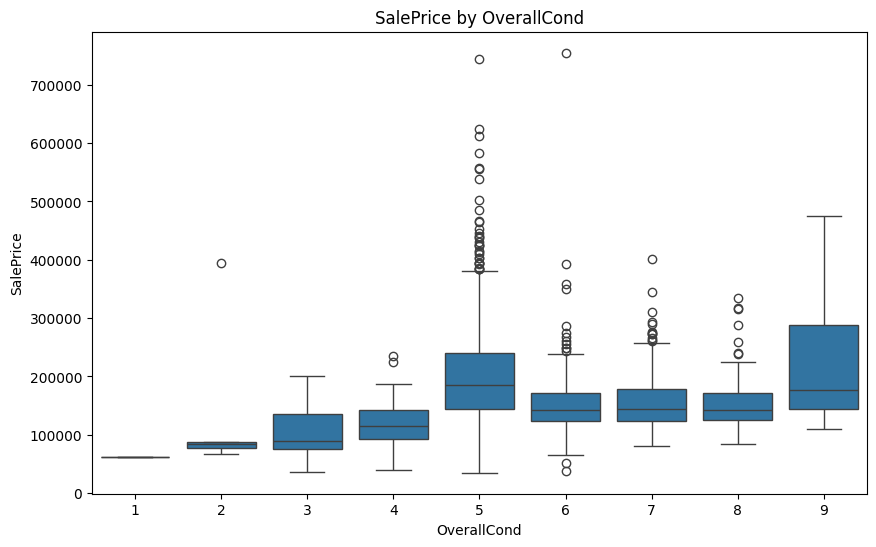

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallCond', y='SalePrice', data=df_train)
plt.title("SalePrice by OverallCond")
plt.show()

Terlihat bahwa rumah dengan kondisi 5 (average) memiliki rentang yang lebih luas dibandingkan yang lain. Bahkan ada rumah dengan kondisi ini mencapai harga termahal kedua setelah rumah dengan kondisi 6 (above average). Kita juga mengetahui bahwa dari data ini tidak ada rumah dengan kondisi 10 (very excellent), kondisi teratas adalah 9 (excellent). Secara umum rumah kondisi 9 memiliki harga yang ada di atas rumah dengan kondisi lain meskipun untuk harga rumah termahal ada pada rumah dengan kondisi 6.

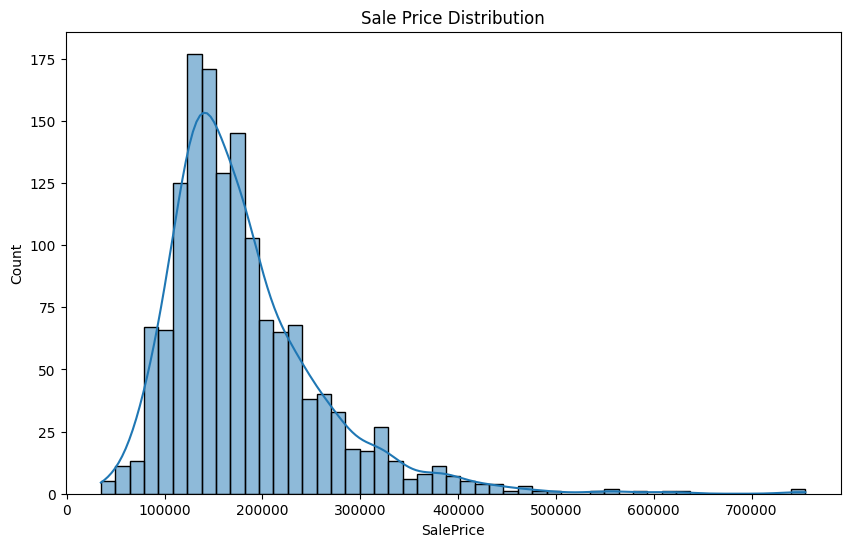

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data = df_train, x = 'SalePrice', kde=True)
plt.title('Sale Price Distribution')
plt.show()

Dari plot histogram di atas, kita tahu bahwa distribusi harga penjualan rumah pada data ini adalah skew positive. Artinya nilai tengah dari harga jual rumah lebih rendah daripada nilai rata-rata nya. Diperoleh juga bahwa jumlah rumah dengan harga pada rentang 120.000 hingga 130.000 adalah yang paling banyak sedangkan pada rentang 700.000 adalah yang paling sedikit.

## Outliers

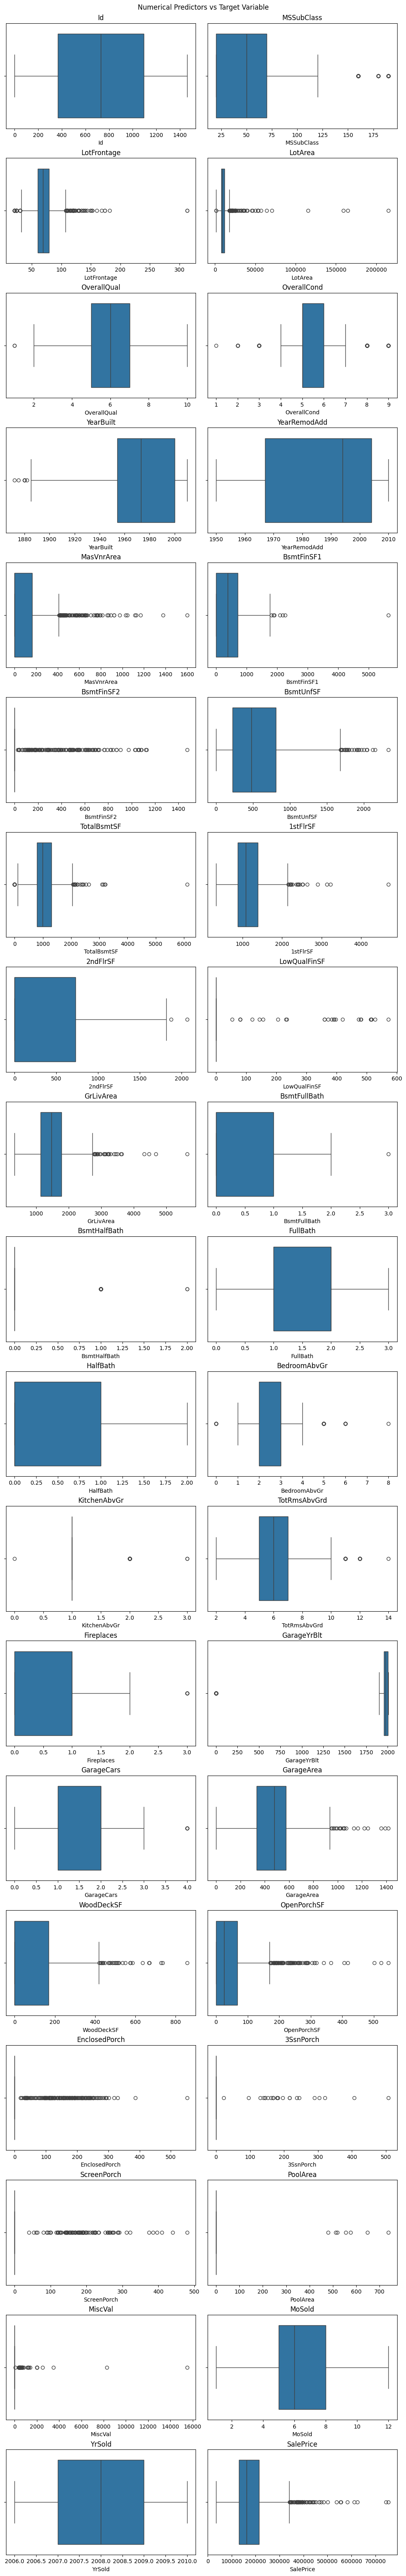

In [ ]:
numerical = df_train.select_dtypes(include=['number']).columns

fig, axes = plt.subplots(19,2, sharex=False, sharey = False, figsize=(10,64), constrained_layout = True)

fig.suptitle('Numerical Predictors vs Target Variable')

col_index = 0

for row in range(19):
  for col in range(2):
    sns.boxplot(ax = axes[row,col], x=df_train[numerical[col_index]])
    axes[row,col].set_title(numerical[col_index])
    col_index += 1

Terlihat bahwa semua features memiliki outliers, kecuali Id, YearRemodAdd, FullBath, HalfBath, MoSold, dan YrSold. Sehingga semua kolom selain itu akan kita atasi dengan log transformation. Tak lupa juga kita tidak akan log transform SalePrice karena merupakan kolom target. Kolom Id akan kita drop karena kurang relevan terhadap prediksi. Akan tetapi perlu diwaspadai, apabila kita tetap memerlukan kolom id untuk submit hasil prediksi data test. Jadi akan kita simpan id pada data test ke variabel df_id.

In [ ]:
X_train = X_train.drop('Id', axis=1)
df_id = df_test['Id']
df_test = df_test.drop('Id', axis=1)

cols = ['Id', 'YearRemodAdd', 'FullBath', 'HalfBath', 'MoSold', 'YrSold', 'SalePrice']
selected = numerical.copy()
selected = selected.drop(cols)

X_train[selected] = np.log(X_train[selected] + 1)
df_test[selected] = np.log(df_test[selected] + 1)

## Mutlicollinearity

Sekarang kita akan cek multicollinearity dari kolom - kolom pada data.

In [ ]:
df_temp = pd.concat([X_train, y_train], axis=1)
df_temp.corr().style.background_gradient(cmap='coolwarm')

Kita peroleh bahwa ada banyak harga mutlak korelasi dari tabel di atas. Dari setiap kelompok feature yang saling berkorelasi, kita cek korelasinya dengan SalePrice dan pilih yang paling besar.

In [ ]:
cols = ['GarageType_NA', 'GarageFinish_NA', 'GarageYrBlt', 'GarageQual_NA', 'GarageCond_NA', 'MiscFeature_NA', 'FireplaceQu_NA',
        'MiscFeature_Shed', 'Exterior2nd_MetalSd', 'Exterior2nd_CmentBd', 'Exterior2nd_VinylSd',
        'Exterior2nd_Other', 'HouseStyle_1Story', 'GrLivArea', 'GarageCars', 'Neighborhood_Somerst', 'MSZoning_RM', 'ExterCond_Gd',
        'BsmtQual_NA', 'BsmtCond_NA', 'BsmtFinType1_NA', 'KitchenQual_Gd', 'RoofStyle_Gable', 'PoolQC_NA', 'Fence_NA']

X_train = X_train.drop(cols, axis=1)

cols.remove('Exterior2nd_Other') #karena tidak ada kolom ini di test
df_test = df_test.drop(cols, axis=1)

## Scaling

Karena rentang pada setiap kolomnya bervariasi, kita akan melakukan scaling menggunakan standard scaler pada kolom-kolom numerik. Beberapa kolom pada X_train sebenarnya adalah data kategorikal maka kita tidak akan scaling data - data tersebut. Jangan lupa untuk hilangkan kolom yang sudah didrop di atas pada variabel numerical.

In [ ]:
# perlu drop id dan saleprice karena kita pakai variabel yang sudah didefine di atas
numerical = numerical.drop(['Id', 'SalePrice', 'GarageYrBlt', 'GrLivArea', 'GarageCars'])
scaler = StandardScaler()

X_train[numerical] = scaler.fit_transform(X_train[numerical])
df_test[numerical] = scaler.transform(df_test[numerical])
X_train.head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.424462    -0.078896 -0.133270     0.689072    -0.460408   1.045180   
1   -1.125202     0.572719  0.113413     0.027742     1.948163   0.163445   
2    0.424462     0.062541  0.420049     0.689072    -0.460408   0.980275   
3    0.645073    -0.329561  0.103317     0.689072    -0.460408  -1.873790   
4    0.424462     0.726089  0.878431     1.272406    -0.460408   0.947798   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0      0.878668    1.203619    0.779431   -0.355342  ...               0   
1     -0.429577   -0.806841    0.888257   -0.355342  ...               0   
2      0.830215    1.131524    0.654803   -0.355342  ...               0   
3     -0.720298   -0.806841    0.384539   -0.355342  ...               0   
4      0.733308    1.423411    0.754400   -0.355342  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 221 columns]

## Model Design

Pada project ini, kita akan menggunakan Gradient Boosting Regressor, XGBoost Regressor, dan LightGBM Regressor sebagai model yang diimplementasikan. Kita akan melakukan hyper parameter tuning dengan menggunakan grid search cv pada tahapan berikutnya. Pada tahap ini, kita akan memanggil model kemudian set beberapa parameter yang akan di tuning.

In [ ]:
gb_model = GradientBoostingRegressor()

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

In [ ]:
xgb_model = XGBRegressor()

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
lgbm_model = LGBMRegressor()

param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0]
}

## Model Training dan Tuning

Sekarang kita akan melakukan model training. Untuk menguji kualitas dari model kita akan menggunakan MAE.

In [ ]:
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, scoring='neg_mean_absolute_error')
grid_search_gb.fit(X_train, y_train)
gb_best = grid_search_gb.best_estimator_
print("Best parameters for Gradient Boosting Regressor:", grid_search_gb.best_params_)
print("Best score:", -grid_search_gb.best_score_)

Best parameters for Gradient Boosting Regressor: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
Best score: 16223.27279551157


In [ ]:
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_absolute_error')
grid_search_xgb.fit(X_train, y_train)
xgb_best = grid_search_xgb.best_estimator_
print("Best parameters for XGBoost Regressor:", grid_search_xgb.best_params_)
print("Best score:", -grid_search_xgb.best_score_)

Best parameters for XGBoost Regressor: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best score: 16443.679238013698


In [ ]:
grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, cv=5, scoring='neg_mean_absolute_error')
grid_search_lgbm.fit(X_train, y_train)
lgbm_best = grid_search_lgbm.best_estimator_
print("Best parameters for LightGBM Regressor:", grid_search_lgbm.best_params_)
print("Best score:", -grid_search_lgbm.best_score_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

Nilai mean absolute error menunjukkan bahwa apabila semakin mendekati ke 0 maka semakin baik performa model. Dari hasil grid search cv di atas, didapat bahwa gradient boosting regressor dengan hasil paramter tuning di atas adalah model yang terbaik untuk kasus ini karena nilai MAE dari prediksi model ini yang paling kecil di antara model yang lain.